# 网页爬取+多模态内容识别+RAG构建本地知识库+中文大语言模型

1. 网页爬取和解析，生成本地元数据 网站： [OrcaStudio使用指南](http://71.136.100.40:3000/?wework_cfm_code=MoL9rcXqCEX2sOXsQF8QRLWWz2NKlLNTXHflPKSOu22ZGPZv%2B4%2BI86KrzytAQ%2F%2FePVNxWUutHYlKRjEP20YhSI0%3D#/README)

2. 分析元数据中的文本和图片，放入 vector store

3. 基于 vector store + qwen 模型的问答功能

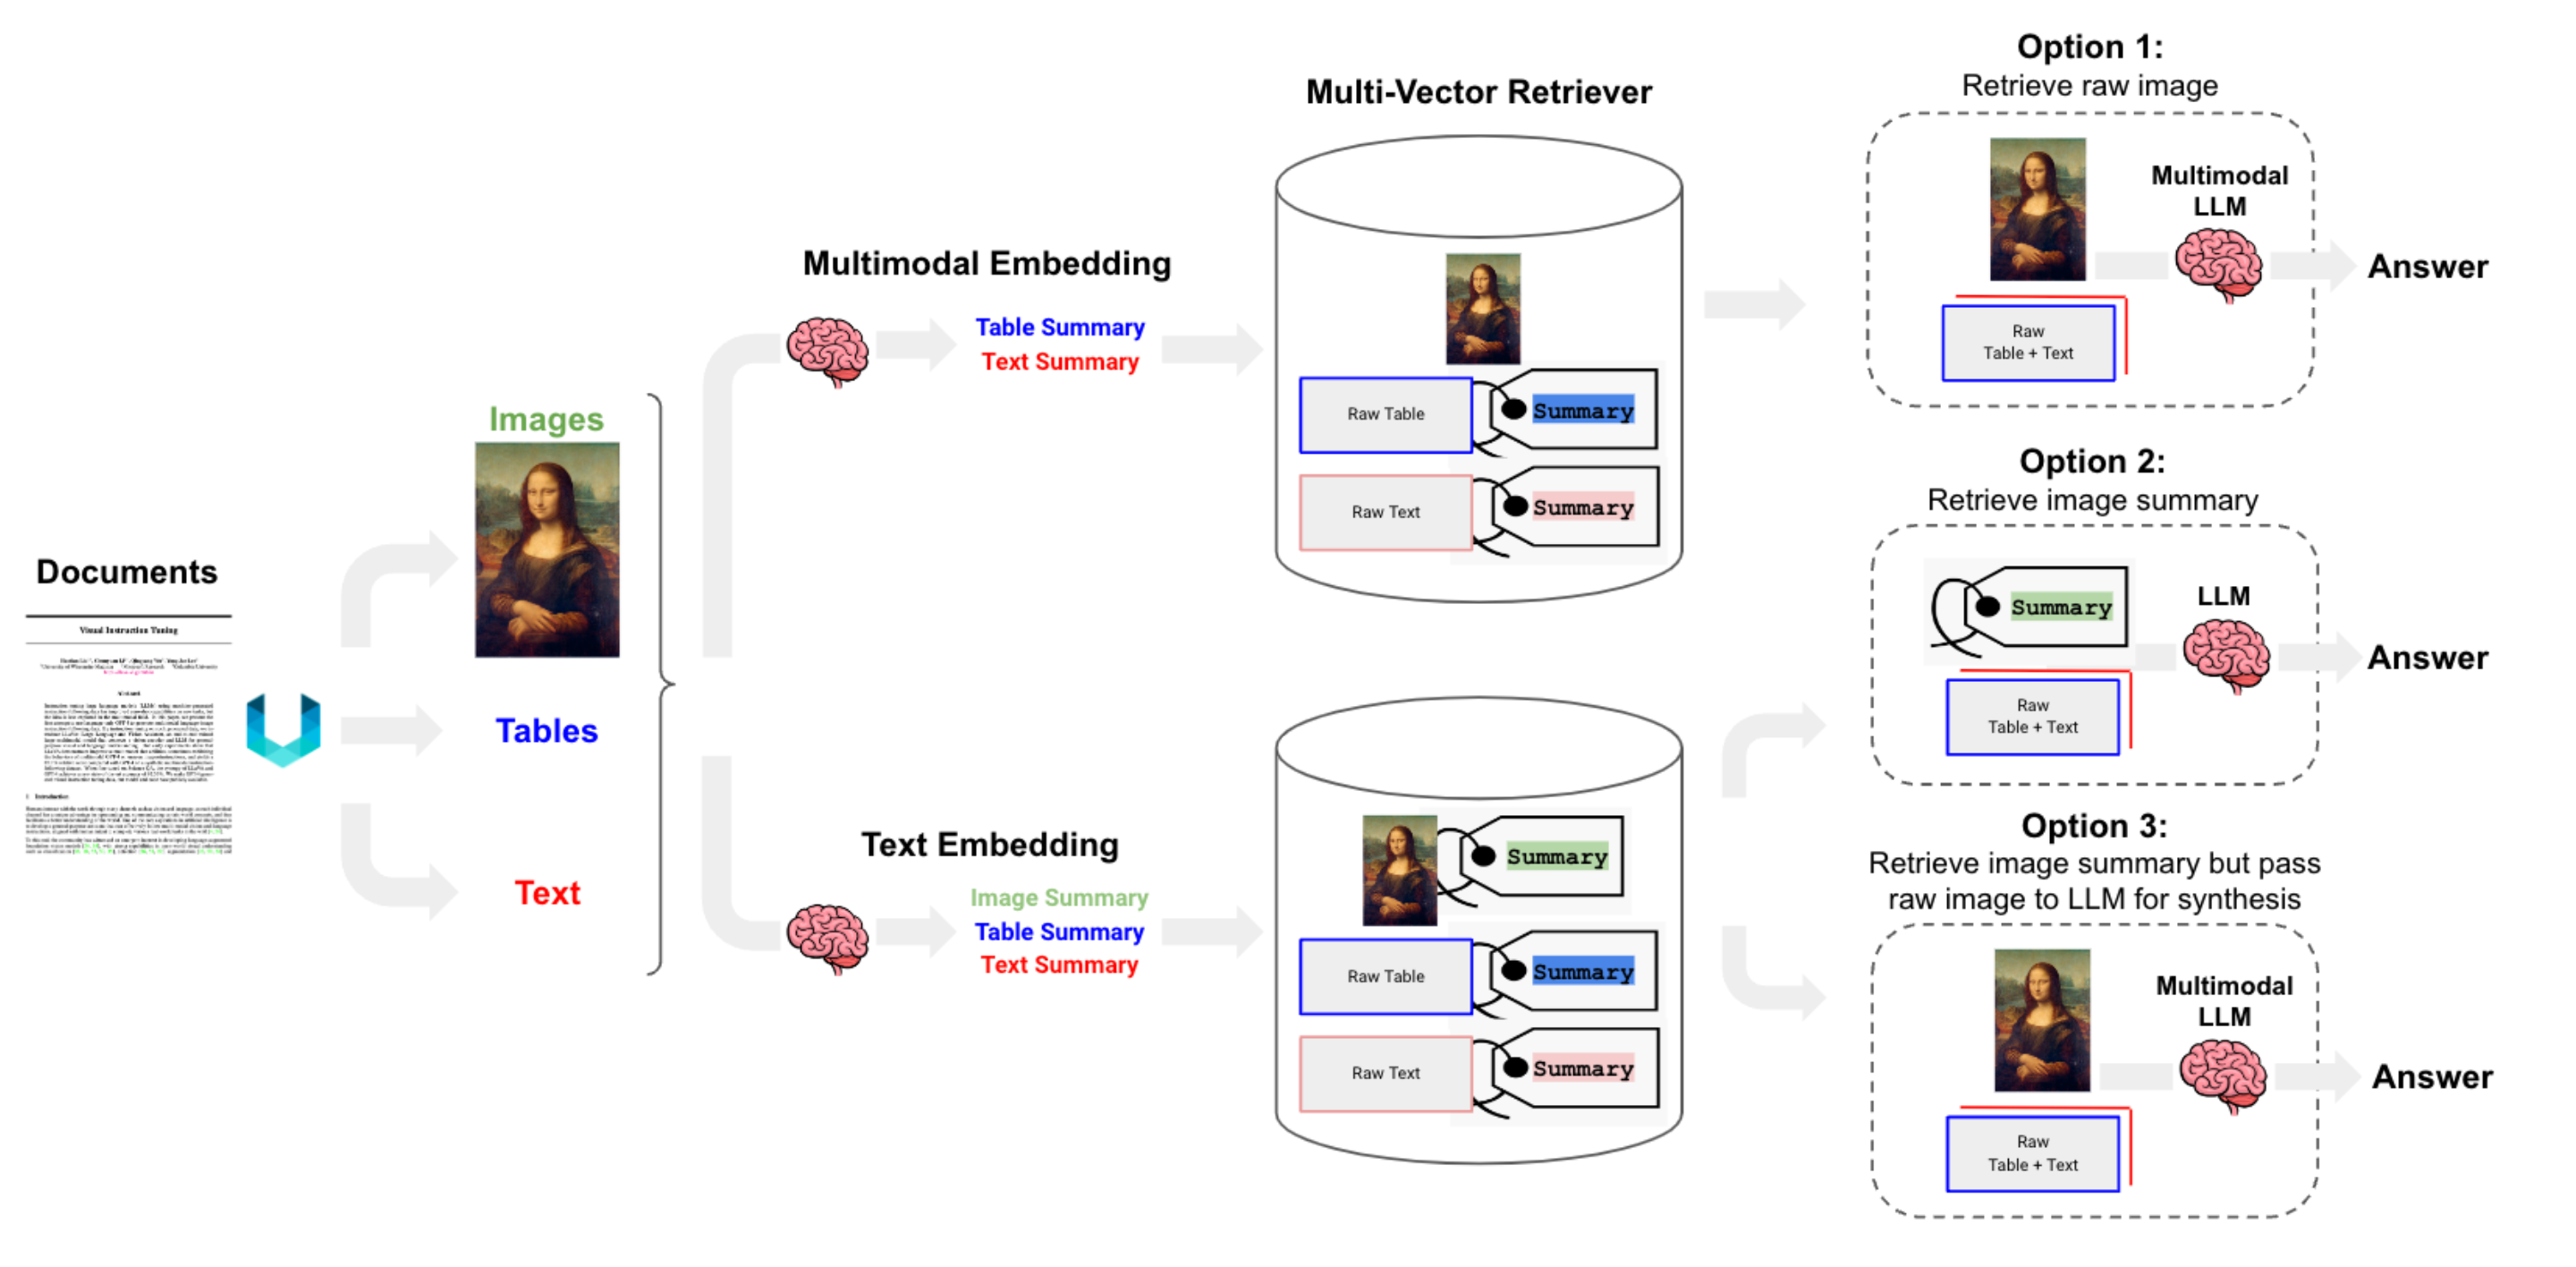



### 网页爬取和解析，生成本地元数据


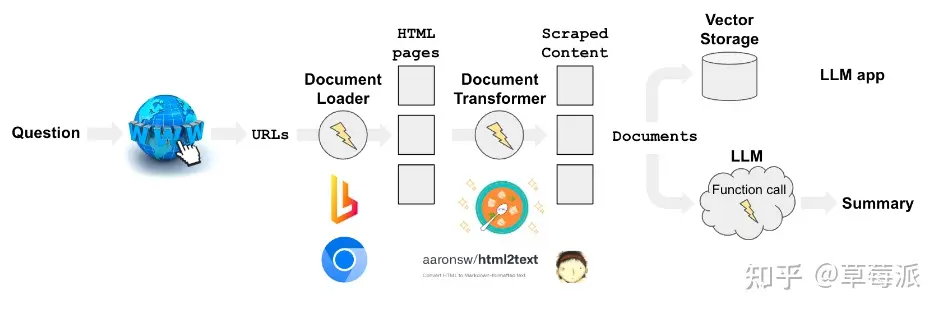

* Question->URLs: 通过URLs来search网页，可以是一个URL，也可以是多个URL

* Document Loader->HTML pages: 用langchain提供的文档加载器获取目标网页的html，如AsyncHtmlLoader, AsyncChromiumLoader等

* Document Transformer->Scraped Content: 用langchain提供的文档转换器工具解析HTML中的需要抓取的信息，如HTML2Tex或Beautiful Soup，形成格式化的文本

`暂时先采用保存到本地的方式保存网页数据`

### 解析HTML

* 从HTML内容中提取文本内容

* 采用unstructured工具进行网页数据读取

In [1]:
from typing import Any
from pydantic import BaseModel
from unstructured.partition.auto import partition

import glob
import os

# Get all .html files in the directory
# path = "/home/huangwei1/Downloads/OrcaStudio_Htmls/"
path = "/home/huangwei1/Downloads/Wechat_Htmls"
file_paths = glob.glob(os.path.expanduser(os.path.join(path, "*.html")))

# Get elements
raw_html_elements_list = []
for file_path in file_paths:
    raw_html_elements_list.append(partition(
        filename=file_path,
        # Using pdf format to find embedded image blocks
        # extract_images_in_pdf=True,
        # Use layout model (YOLOX) to get bounding boxes (for tables) and find titles
        # Titles are any sub-section of the document
        infer_table_structure=True,
        # Post processing to aggregate text once we have the title

        chunking_strategy="by_title",
        # Chunking params to aggregate text blocks
        # Attempt to create a new chunk 3800 chars
        # Attempt to keep chunks > 2000 chars
        # Hard max on chunks
        max_characters=4000,
        new_after_n_chars=3800,
        combine_text_under_n_chars=2000,
        image_output_dir_path=path,
    ))

In [2]:
# Create a dictionary to store counts of each type
category_counts = {}

for raw_html_elements in raw_html_elements_list:
    for element in raw_html_elements:
        category = str(type(element))
        if category in category_counts:
            category_counts[category] += 1
        else:
            category_counts[category] = 1

# Unique_categories will have unique elements
# TableChunk if Table > max chars set above
unique_categories = set(category_counts.keys())
category_counts

/home/huangwei1/Downloads/Wechat_Htmls/texts_parsed.json


In [3]:
class Element(BaseModel):
    type: str
    text: Any


# Categorize by type
categorized_elements = []

for raw_html_elements in raw_html_elements_list:
    for element in raw_html_elements:
        if "unstructured.documents.elements.Table" in str(type(element)):
            categorized_elements.append(Element(type="table", text=str(element)))
        elif "unstructured.documents.elements.CompositeElement" in str(type(element)):
            categorized_elements.append(Element(type="text", text=str(element)))

# Tables
table_elements = [e for e in categorized_elements if e.type == "table"]
# print(table_elements)

# Text
text_elements = [e for e in categorized_elements if e.type == "text"]
# print(text_elements)
# print(len(text_elements))

# Image
image_elements = [e for e in categorized_elements if e.type == "image"]
# print(image_elements)

* 使用LLM提取文本摘要

In [4]:
from langchain_community.chat_models import ChatOllama
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate

In [5]:
# Prompt
prompt_text = """你是一个科技和计算机领域的助理，负责总结表格和文本。＼
基于科技和计算机领域知识，给出表格或文本的详细摘要。表格或文本块: {element} """
prompt = ChatPromptTemplate.from_template(prompt_text)

# Summary chain
qwen_model = ChatOllama(model="qwen:32b-chat-v1.5-q5_K_M")
summarize_chain = {"element": lambda x: x} | prompt | qwen_model | StrOutputParser()

In [6]:
print(len(text_elements))

# Apply to text （注意：运行时间很长）
texts = [i.text for i in text_elements if i.text != ""]
text_summaries = summarize_chain.batch(texts, {"max_concurrency": 5})


35


* 持久化原始文本和摘要

In [7]:
print(len(text_summaries))
print(len(texts))

import json
import codecs

txt_data = []

for i in range(0, len(texts)):
    d = {
        "summary" : text_summaries[i],
        "text" : texts[i]
    }
    txt_data.append(d)

if len(txt_data) > 0:
    json_file = codecs.open(os.path.join(path, "texts_parsed.json"), 'w', 'utf-8')
    json_str = json.dumps(txt_data, ensure_ascii=False)
    json_file.write(json_str)


35
35


### 分析图片

* 遍历文件夹，检查所有的png,jpg文件，对于 width/height >= 128 的才处理，太小的图片没有有价值的信息

* 所有图片整理成list，送给 llava 进行分析，提取摘要

* 持久化摘要，后续和文本一起进行向量化

In [2]:
import os
import glob
from PIL import Image


def find_matched_img(path):
    image_file_paths = []
    MIN_WIDTH = 128
    MIN_HEIGHT = 128

    paths_walked = os.walk(path)
    for path, dir_lst, file_lst in paths_walked:
        for dir_name in dir_lst:
            # Get all .jpg/png files in the directory
            img_file_paths = glob.glob(os.path.join(path,(os.path.join(dir_name, "*.[jJ][pP][gG]"))))
            img_file_paths.extend(glob.glob(os.path.join(path,(os.path.join(dir_name, "*.[pP][nN][gG]")))))
            img_file_paths.extend(glob.glob(os.path.join(path,(os.path.join(dir_name, "*.[gG][iI][fF]")))))
            img_file_paths.extend(glob.glob(os.path.join(path,(os.path.join(dir_name, "*.[wW][eE][bB][pP]")))))

            for img_path in img_file_paths:
                img = Image.open(img_path)
                if img.width >= MIN_WIDTH and img.height >= MIN_HEIGHT:
                    image_file_paths.append(img_path)
    return image_file_paths


image_file_paths = find_matched_img(path)
print(len(image_file_paths))


43


* 将图片转为适合html显示的格式

In [3]:
import base64
from io import BytesIO

from IPython.display import HTML, display
from PIL import Image


def convert_to_base64(pil_image):
    """
    Convert PIL images to Base64 encoded strings

    :param pil_image: PIL image
    :return: Re-sized Base64 string
    """

    buffered = BytesIO()
    pil_image.save(buffered, format="png")  # You can change the format if needed
    img_str = base64.b64encode(buffered.getvalue()).decode("utf-8")
    return img_str


def plt_img_base64(img_base64):
    """
    Disply base64 encoded string as image

    :param img_base64:  Base64 string
    """
    # Create an HTML img tag with the base64 string as the source
    image_html = f'<img src="data:image/jpeg;base64,{img_base64}" />'
    # Display the image by rendering the HTML
    display(HTML(image_html))


In [4]:
from langchain_community.chat_models import ChatOllama
from langchain_core.messages import HumanMessage
from langchain_core.output_parsers import StrOutputParser

llava_model = ChatOllama(model="llava:34b-v1.6-q5_K_M")

def prompt_func(data):
    text = data["text"]
    image = data["image"]

    image_part = {
        "type": "image_url",
        "image_url": f"data:image/jpeg;base64,{image}",
    }

    content_parts = []

    text_part = {"type": "text", "text": text}

    content_parts.append(image_part)
    content_parts.append(text_part)

    return [HumanMessage(content=content_parts)]

chain = prompt_func | llava_model | StrOutputParser()


* 先生成html图片对象，再进行分析。ollama框架运行llava时，采用这种方式输入图片结果较为稳定，直接在提示词中指定图片路径容易出现幻觉


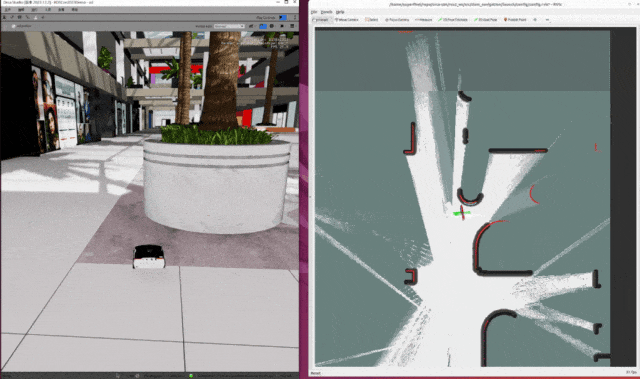

抱歉，由于您提供的图片没有显示出来，我无法为您分析图片的内容。如果您有其他问题需要帮助，请随时提问！<|im_end|>



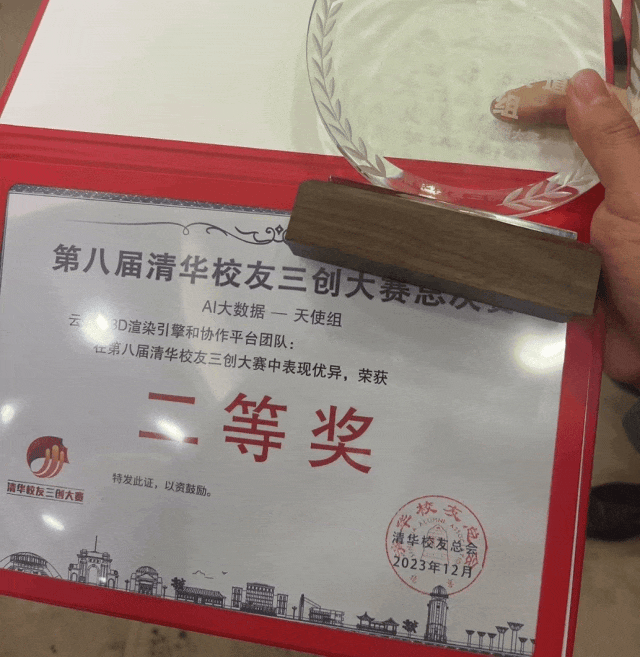

很抱歉，由于图片中显示的内容是中文的获奖证书和奖杯，而且文字内容无法识别，因此我无法确定这枚奖牌具体与计算机领域哪个方面相关。通常，这样的奖项可能颁发给在计算机领域有杰出成就的个人或团队，比如优秀编程项目、创新技术应用、学术论文发表等等。

但是，我可以描述一下图片中的内容：它显示的是一个红色的证书和一个奖杯。证书上写着一些中文文字，但具体内容无法识别。奖杯上也有中文文字，不过同样由于图像模糊和文字过小而难以辨认具体内容。奖杯的形状类似于一座小小的建筑或大厦，可能象征着荣誉、成就或者某个特定的主题。

如果需要更具体的细节，可能需要提供更清晰的图片或者描述证书上的文字。<|im_end|>



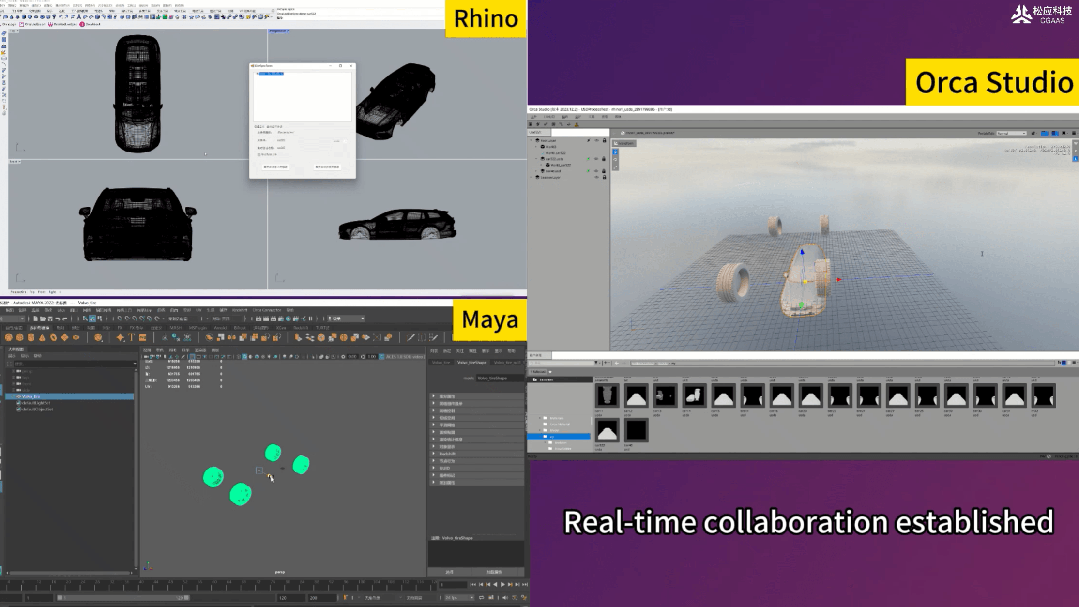

根据图片中的内容，这是关于计算机领域中涉及到3D建模和渲染、图像处理以及软件开发的内容。具体描述如下：

1. 第一幅图显示的是一个3D建模软件的工作界面。我们可以看到软件工具栏，模型视口，以及一些3D几何体（如立方体、球体等）的预览图，这可能表示用户正在使用该软件进行三维模型的创建或编辑工作。
2. 第二幅图展示的是一个图像处理软件的工作界面。这个界面显示了颜色直方图，这可能是用于分析图像中每个通道的颜色分布情况。此外，还有一些调整面板，可能用于调节图像的色彩、对比度等参数。
3. 第三幅图显示了一个实时协作工具的工作界面。我们可以看到多个用户同时参与编辑同一个文档（如文本文件），这可能表示该软件具备多人协同编辑的功能，以实现团队协作和实时交流。
4. 最后一幅图展示的是一个软件开发工具的工作界面。我们可以看到代码编辑器、调试面板、变量监视器等元素，这些是典型的集成开发环境（IDE）中用于编写、调试和运行程序的工具。

综上所述，这张图片可能是在计算机领域中涉及到3D建模渲染、图像处理、实时协作以及软件开发等方面的内容。它展示的是一些常见软件工具的工作界面，以示用户在操作过程中的步骤和方法。<|im_end|>



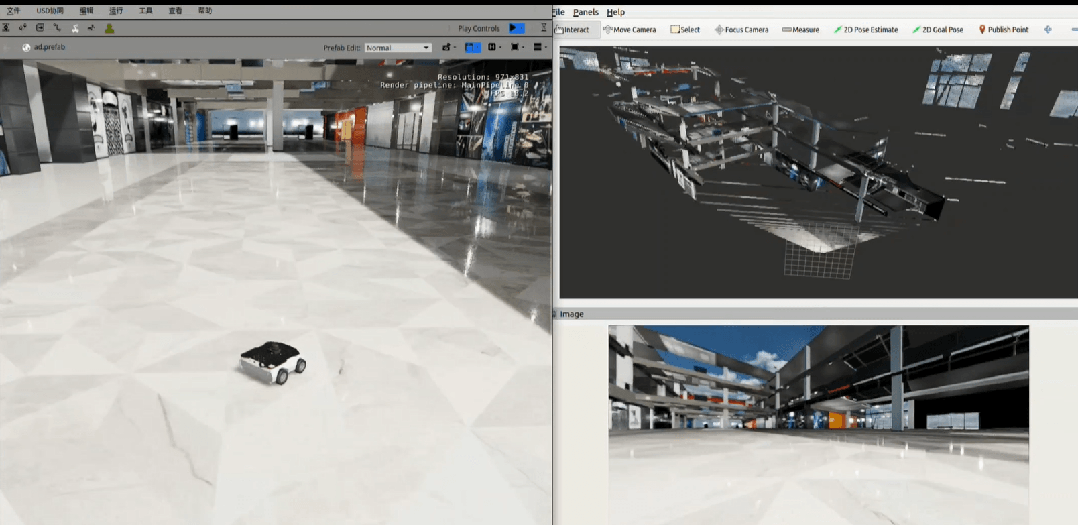

这张图片看起来是由多张不同主题的图片拼贴而成，并没有一个统一的主题。这些图片可能涉及计算机领域的多个方面，比如：

1. 硬件设备：可能是一些计算机硬件组件的照片，例如CPU、GPU、内存条、主板等。
2. 软件界面：可能是各种软件的应用界面截图，包括操作系统、应用软件、游戏画面等等。
3. 科技产品：可能涉及最新的电脑硬件、手机、平板电脑等科技产品的外观图片。
4. 数据可视化：可能是一些数据图表或者信息图的截图，用于展示数据分析的结果。
5. 编程代码：可能会是一些编程语言的代码段截图，或者是某种编程环境的截图。
6. 互联网服务：可能涉及社交平台、搜索引擎、电商平台等互联网服务的网页截图。
7. 虚拟现实/增强现实：可能是VR或者AR设备的照片，或者是相关应用的截图。
8. 计算机艺术作品：可能是一些用计算机技术创作的艺术作品的截图，例如3D建模、数字绘画等等。
9. 教育培训：可能是有关计算机技能培训的资料图片。
10. 人工智能：可能涉及人工智能相关的应用或者算法模型展示的图片。

由于图片不清晰且是拼接而成，无法确定具体的内容。如果需要了解更详细的信息，可能需要提供更多的上下文信息或具体的图片内容。<|im_end|>



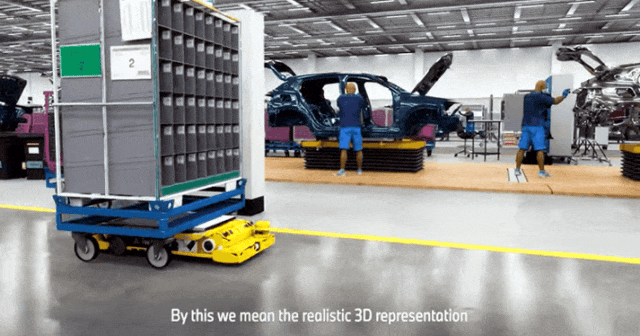

KeyboardInterrupt: 

In [5]:
import time

image_summaries = []

for file_path in image_file_paths:
    pil_image = Image.open(file_path)

    image_b64 = convert_to_base64(pil_image)
    plt_img_base64(image_b64)

    # 延迟一会，否则可能认不清图片
    time.sleep(5)

    # （注意：运行时间很长）
    query_chain = chain.invoke(
        {"text": "你是计算机专业领域的助理，以下图片的可能是关于计算机领域的哪方面内容的？并且，请基于上面的判断，详细描述图片中的内容。图片：", "image": image_b64}
    )

    print(query_chain)
    image_summaries.append(query_chain)

* 持久化图片摘要，存储到json文件

In [31]:
print(len(image_summaries))
print(len(image_file_paths))

import json
import codecs

img_data = []

for i in range(0, len(image_summaries)):
    d = {
        "summary" : image_summaries[i],
        "img_file" : image_file_paths[i]
    }
    img_data.append(d)

if len(img_data) > 0:
    json_file = codecs.open(os.path.join(path, "image_parsed.json"), 'w', 'utf-8')
    json_str = json.dumps(img_data, ensure_ascii=False)
    json_file.write(json_str)    

43
43


### 使用 vector storage 完成RAG

* Use [Multi Vector Retriever](https://python.langchain.com/docs/modules/data_connection/retrievers/multi_vector#summary) with summaries.

* 读取先前持久化的文本原文和摘要

* summaries 需要向量化，Embedding采用北京人工智能研究院的 bge 模型，存储在 Chroma DB 中

In [35]:
import uuid

from langchain.retrievers.multi_vector import MultiVectorRetriever
from langchain.storage import InMemoryStore
# from langchain_community.embeddings import GPT4AllEmbeddings
from langchain_community.embeddings import OllamaEmbeddings
from langchain_community.vectorstores import Chroma
from langchain_core.documents import Document

# The vectorstore to use to index the child chunks
vectorstore = Chroma(
    # collection_name="summaries", embedding_function=GPT4AllEmbeddings()
    collection_name="summaries", embedding_function=OllamaEmbeddings(model="znbang/bge:large-zh-v1.5-f16")
)

# The storage layer for the parent documents
store = InMemoryStore()  # <- Can we extend this to images
id_key = "doc_id"

# The retriever (empty to start)
retriever = MultiVectorRetriever(
    vectorstore=vectorstore,
    docstore=store,
    id_key=id_key,
)

* Store the image summary in the `docstore`, which we return to the LLM for answer generation.

In [36]:

import json
import codecs

# Load texts
def load_text_vectorstore(path):
    data_load = json.loads(codecs.open(path, 'r', 'utf-8').read())
    print(len(data_load))

    texts_load = []
    text_summaries_load = []
    for data in data_load:
        texts_load.append(data['text'])
        text_summaries_load.append(data['summary'])

    # Add texts
    doc_ids = [str(uuid.uuid4()) for _ in texts_load]
    summary_texts = [
        Document(page_content=s, metadata={id_key: doc_ids[i]})
        for i, s in enumerate(text_summaries_load)
    ]
    retriever.vectorstore.add_documents(summary_texts)
    retriever.docstore.mset(list(zip(doc_ids, texts_load)))

# Load images
def load_image_vectorstore(path):
    data_load = json.loads(codecs.open(path, 'r', 'utf-8').read())
    print(len(data_load))

    image_path_load = []
    image_summaries_load = []
    for data in data_load:
        image_path_load.append(data['img_file'])
        image_summaries_load.append(data['summary'])


    # Add images
    img_ids = [str(uuid.uuid4()) for _ in image_summaries_load]
    summary_img = [
        Document(page_content=s, metadata={id_key: img_ids[i]})
        for i, s in enumerate(image_summaries_load)
    ]
    retriever.vectorstore.add_documents(summary_img)
    retriever.docstore.mset(
        list(zip(img_ids, image_summaries_load))
    )  # Store the image summary as the raw document


load_text_vectorstore("/home/huangwei1/Downloads/OrcaStudio_Htmls/texts_parsed.json")
load_text_vectorstore("/home/huangwei1/Downloads/Wechat_Htmls/texts_parsed.json")
load_image_vectorstore("/home/huangwei1/Downloads/OrcaStudio_Htmls/image_parsed.json")
load_image_vectorstore("/home/huangwei1/Downloads/Wechat_Htmls/image_parsed.json")

67
35
82
43


In [37]:
retriever.get_relevant_documents("Orca Studio")[
    0
]

'Orca Studio 中的 Datalink 就完全可以做跨地区、跨团队、跨数据的实时互通，任何改动都是实时动态更新给每个人。\n\n此外，多种专业建模、设计软件支撑各行业的实时工作。\n\n比如接入的 3D Max、MAYA、Blender、Houdin，就可以做动画、做游戏、做设计；\n\n像 Rhino 和 BIM，就可以做建筑工程。\n\nOrca Studio 就是像一个实用的集市，Launcher（桌面系统）里面有很多组件，客户可以按照需要挑选设计、建模软件，随后组合就成了一个互通的小系统。\n\n比如用ORCA接入机器人ROS系统，再接上仿真软件和数个Rader传感器，就构成一个机器人的仿真模拟平台，就可以为机器人训练服务。同样，松应还对接了多家国内外AI大模型平台，为机器人提供智能化训练环境。\n\n这一个个灵活的小系统，就变成了企业和团队工作的 team center。\n\n各团队在工作的时候，各司其职，且不会出差错。\n\n在 2024 年，松应科技 Orca Studio 将紧密与AI人工智能结合，去深入服务大模型企业、智能机器人、无人机行业。\n\n目前平台里不断接入多类型的摄像头、毫米波、激光雷达，用来模拟机器人或者无人机在多视角里的各种探测活动。\n\n同时，也可以根据客户的需求和场景，为他们开发专属的解决方案，满足他们的个性化需求。\n\nOrca Studio 工业机器人仿真模拟场景\n\nOrca Studio 工业机器人仿真模拟场景\n\nOrca Sim 多机器人物理模拟场景\n\n更远的未来，松应科技希望一步一个脚印地、打造工业元宇宙的核心基座。\n\n工业元宇宙的广阔天地中，拥有无限可能性，但其中的挑战也同样明显。\n\n要想让工业元宇宙真正释放其潜力，关键在于如何打造一个简单易用、具有高度扩展性的基座。\n\n英伟达的成功历史提供了宝贵的启示。\n\n他们设计的并行计算平台 CUDA，通过不断简化使用难度，吸引了越来越多的用户和开发者。\n\n这就像是为工业元宇宙搭建了一座坚固的基石，使得各种应用场景得以迅速涌现。\n\n这不仅仅是因为他们的软件做得好，更重要的是，他们成功降低了学习成本，让更多的人能够轻松上手，进而激发出无限的创新力量。\n\n在工业元宇宙中，同样也需要这样一个基座。\n\n它应该通过抽象的 API

In [38]:
from langchain_core.runnables import RunnablePassthrough
from langchain_community.chat_models import ChatOllama
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate

qwen_model = ChatOllama(model="qwen:32b-chat-v1.5-q5_K_M")

# Prompt template
template = """你是一个科技和计算机领域的助理，仅根据以下上下文，详细地回答问题。上下文:
{context}
问题: {question}
"""
prompt = ChatPromptTemplate.from_template(template)


# RAG pipeline
chain = (
    {"context": retriever, "question": RunnablePassthrough()}
    | prompt
    | qwen_model
    | StrOutputParser()
)

In [42]:
print(chain.invoke(
    "Datalink可以跨地区、跨团队、跨数据的实时互通吗"
))

是的，Datalink能够实现跨地区、跨团队、跨数据的实时互通。它提供了一个平台，允许用户在不同的地理位置和团队之间共享和协同编辑USD格式的文件。通过livesync项目示例，可以实现实时同步功能，这意味着团队成员可以在不同时区或不同地点对同一个USD文件进行修改，并且这些变更会立即反映给所有其他已加入同一会话的用户。这样就支持了远程协作和异步工作流程，提高了效率并减少了数据孤岛的问题。
